# Objective

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Identify which questions asked on Quora are duplicates of questions that have already been asked.

This could be useful to instantly provide answers to questions that have already been answered.

We are tasked with predicting whether a pair of questions are duplicates or not.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [13]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [14]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [15]:
X_train,X_test, y_train, y_test = train_test_split(df[['id','qid1','qid2','question1','question2']], df['is_duplicate'], test_size=0.3)

In [16]:
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, min_df =5, max_features=100)
tfidf_train = tfidf.fit(questions)
tfidf_train_q1 = tfidf.transform(X_train['question1'])
tfidf_train_q2 = tfidf.transform(X_train['question2'])
tfidf_test_q1 = tfidf.transform(X_test['question1'])
tfidf_test_q2 = tfidf.transform(X_test['question2'])

In [17]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(tfidf_train_q1)
# transform both train and test data
final_tfidf_train_q1 = scaler.transform(tfidf_train_q1)
final_tfidf_test_q1 = scaler.transform(tfidf_test_q1)
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(tfidf_train_q2)
# transform both train and test data
final_tfidf_train_q2 = scaler.transform(tfidf_train_q2)
final_tfidf_test_q2 = scaler.transform(tfidf_test_q2)

In [8]:
df_train_q1 = pd.DataFrame(final_tfidf_train_q1.toarray())
df_train_q2 = pd.DataFrame(final_tfidf_train_q2.toarray())
df_test_q1 = pd.DataFrame(final_tfidf_test_q1.toarray())
df_test_q2 = pd.DataFrame(final_tfidf_test_q2.toarray())

In [9]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [10]:
dfnlp = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
dfppro = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [11]:
dfnlp_train = X_train.merge(dfnlp, on='id',how='left')

In [12]:
dfnlp_test = X_test.merge(dfnlp, on='id',how='left')

In [13]:
dfppro_train = X_train.merge(dfppro, on='id',how='left')

In [14]:
dfppro_test = X_test.merge(dfppro, on='id',how='left')

In [15]:
df_train_q1['id']=dfnlp_train['id']
df_train_q2['id']=dfnlp_train['id']
df_test_q1['id']=dfnlp_test['id']
df_test_q2['id']=dfnlp_test['id']

In [16]:
Train1  = dfnlp_train.merge(dfppro_train, on='id',how='left')
Train2  = df_train_q1.merge(df_train_q2, on='id',how='left')
Train_final  = Train1.merge(Train2, on='id',how='left')

In [17]:
Test1  = dfnlp_test.merge(dfppro_test, on='id',how='left')
Test2  = df_test_q1.merge(df_test_q2, on='id',how='left')
Test_final  = Test1.merge(Test2, on='id',how='left')

In [18]:
# remove the first row 
Train_final.drop(Train_final.index[0], inplace=True)
y_train1 = Train_final['is_duplicate']
Train_final.drop(['id','qid1_x','qid2_x','question1_x','question2_x','is_duplicate','qid1_y',
                 'qid2_y', 'question1_y', 'question2_y'], axis=1, inplace=True)

In [19]:
Train_final.shape

(283002, 226)

In [20]:
y_train1.shape

(283002,)

In [21]:
# remove the first row 
Test_final.drop(Test_final.index[0], inplace=True)
y_test1 = Test_final['is_duplicate']
Test_final.drop(['id','qid1_x','qid2_x','question1_x','question2_x','is_duplicate','qid1_y',
                 'qid2_y', 'question1_y', 'question2_y'], axis=1, inplace=True)

In [22]:
Test_final.shape

(121286, 226)

In [23]:
y_test1.shape

(121286,)

In [24]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4208279025433137
For values of alpha =  0.0001 The log loss is: 0.41567707312247903
For values of alpha =  0.001 The log loss is: 0.4167490390126984
For values of alpha =  0.01 The log loss is: 0.41903820415582893
For values of alpha =  0.1 The log loss is: 0.43019794422154717
For values of alpha =  1 The log loss is: 0.4769929873119855
For values of alpha =  10 The log loss is: 0.544413884214314


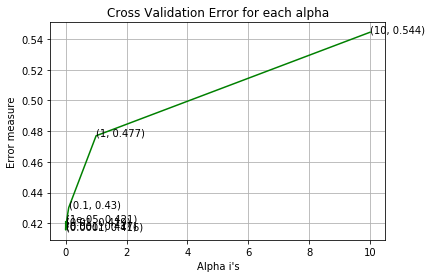

For values of best alpha =  0.0001 The train log loss is: 0.41544946823904405
For values of best alpha =  0.0001 The test log loss is: 0.41567707312247903
Total number of data points : 121286


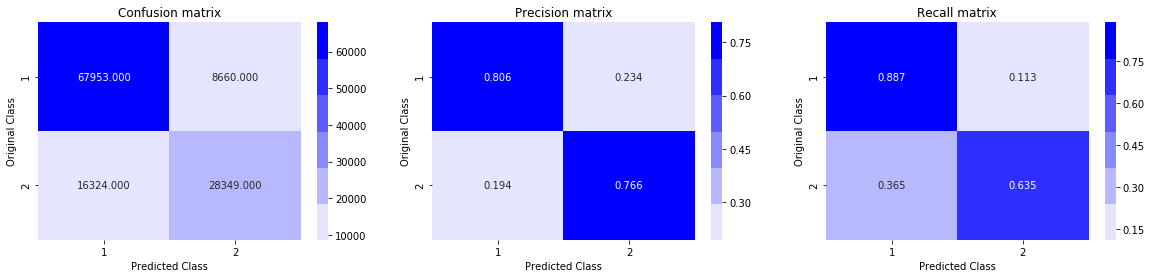

In [98]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(Train_final, y_train1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Train_final, y_train1)
    predict_y = sig_clf.predict_proba(Test_final)
    log_error_array.append(log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(Train_final, y_train1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(Train_final, y_train1)

predict_y = sig_clf.predict_proba(Train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train1, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(Test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test1, predicted_y)

# Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.43686391047783546
For values of alpha =  0.0001 The log loss is: 0.4656856276673288
For values of alpha =  0.001 The log loss is: 0.4711323558104351
For values of alpha =  0.01 The log loss is: 0.4901322083347009
For values of alpha =  0.1 The log loss is: 0.5490466460749789
For values of alpha =  1 The log loss is: 0.5594305552480202
For values of alpha =  10 The log loss is: 0.6498188815430253


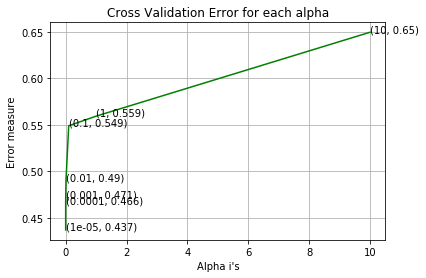

For values of best alpha =  1e-05 The train log loss is: 0.43805787139544455
For values of best alpha =  1e-05 The test log loss is: 0.43686391047783546
Total number of data points : 121286


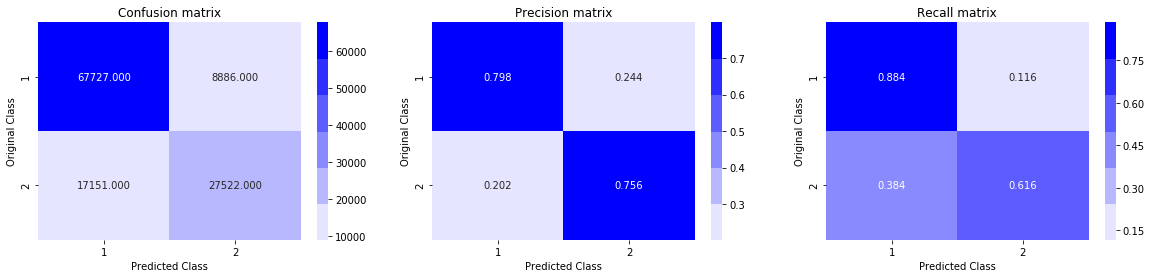

In [99]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(Train_final, y_train1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Train_final, y_train1)
    predict_y = sig_clf.predict_proba(Test_final)
    log_error_array.append(log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(Train_final, y_train1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(Train_final, y_train1)

predict_y = sig_clf.predict_proba(Train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train1, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(Test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test1, predicted_y)

# TFIDF-W2V

In [21]:
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit(questions)
# tfidf_train_q1 = tfidf.transform(X_train['question1'])
# tfidf_train_q2 = tfidf.transform(X_train['question2'])
# tfidf_test_q1 = tfidf.transform(X_test['question1'])
# tfidf_test_q2 = tfidf.transform(X_test['question2'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m_train'] = list(vecs1)

100%|███████████████████████████████████████████████████████████████████████▉| 282738/283003 [1:12:45<00:07, 36.35it/s]

In [24]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m_train'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 283003/283003 [1:57:47<00:00, 40.04it/s]


In [25]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m_test'] = list(vecs1)

100%|██████████████████████████████████████████████████████████████████████████| 121287/121287 [49:44<00:00, 40.64it/s]


In [26]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q2_feats_m_test'] = list(vecs1)

100%|██████████████████████████████████████████████████████████████████████████| 121287/121287 [50:20<00:00, 40.15it/s]


In [27]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [28]:
dfnlp = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
dfppro = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [29]:
df3_train = X_train.drop(['qid1','qid2','question1','question2'],axis=1)
df3_q1_train = pd.DataFrame(df3_train.q1_feats_m_train.values.tolist(), index= df3_train.index)
df3_q2_train = pd.DataFrame(df3_train.q2_feats_m_train.values.tolist(), index= df3_train.index)

In [30]:
df3_test = X_test.drop(['qid1','qid2','question1','question2'],axis=1)
df3_q1_test = pd.DataFrame(df3_test.q1_feats_m_test.values.tolist(), index= df3_test.index)
df3_q2_test = pd.DataFrame(df3_test.q2_feats_m_test.values.tolist(), index= df3_test.index)

In [31]:
df3_q1_train['id']=X_train['id']
df3_q2_train['id']=X_train['id']
df3_q1_test['id']=X_test['id']
df3_q2_test['id']=X_test['id']

In [32]:
dfnlp_train = df3_q1_train.merge(dfnlp, on='id',how='left')
dfnlp_test = df3_q1_test.merge(dfnlp, on='id',how='left')
df_train = dfnlp_train.merge(dfppro, on='id',how='left')
df_test = dfnlp_test.merge(dfppro, on='id',how='left')

In [4]:
# remove the first row 
#df_train.drop(dfnlp_train.index[0], inplace=True)
df_y_train = df_train['is_duplicate']
df_train.drop(['id','is_duplicate'], axis=1, inplace=True)

In [5]:
# remove the first row 
#df_test.drop(df_test.index[0], inplace=True)
df_y_test = df_test['is_duplicate']
df_test.drop(['id','is_duplicate'], axis=1, inplace=True)

In [33]:
import pickle
file = open("df_train.pkl",'wb')
pickle.dump(df_train,file)
file.close()

In [34]:
file = open("df_test.pkl",'wb')
pickle.dump(df_test,file) 
file.close()

In [1]:
import pickle
file = open('df_train.pkl','rb')
df_train = pickle.load(file)
file.close()

In [2]:
file = open('df_test.pkl','rb')
df_test = pickle.load(file)
file.close()

# XGB with hyperparameter tuning

In [11]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
clf = xgb.XGBClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(df_test, df_y_test)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=10,
                            n_jobs=-1, verbose=5, cv=3,
                            fit_params=fit_params,
                            scoring='neg_log_loss',)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(df_train, df_y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 126.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 126.2min finished


[04:34:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1036 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-logloss:0.648911
Will train until validation_0-logloss hasn't improved in 10 rounds.
[04:34:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1028 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-logloss:0.608342
[04:34:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-logloss:0.573646
[04:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1078 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-logloss:0.547592
[04:34:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 890 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation_0-logloss:0.

[04:41:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[43]	validation_0-logloss:0.332373
[04:41:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[44]	validation_0-logloss:0.331857
[04:42:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[45]	validation_0-logloss:0.331392
[04:42:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[46]	validation_0-logloss:0.330963
[04:42:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[47]	validation_0-logloss:0.330546
[04:42:33] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[04:48:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 0 pruned nodes, max_depth=10
[86]	validation_0-logloss:0.319687
[04:49:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1016 extra nodes, 0 pruned nodes, max_depth=10
[87]	validation_0-logloss:0.319544
[04:49:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[88]	validation_0-logloss:0.319474
[04:49:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 996 extra nodes, 0 pruned nodes, max_depth=10
[89]	validation_0-logloss:0.319387
[04:49:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[90]	validation_0-logloss:0.319242
[04:49:46] C:\Users\Administrator\Desktop\xgboost\src\tree\

In [12]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10
params['subsample'] =0.9
params['reg_lambda']=1.0
params['n_estimators'] =100
params['min_child_weight']=5.0
params['learning_rate']=0.1
params['gamma']=0
params['colsample_bytree']=0.7
params['colsample_bylevel']=1.0

d_train = xgb.DMatrix(df_train, label=df_y_train)
d_test = xgb.DMatrix(df_test, label=df_y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(df_train,df_y_train)
predict_y = bst.predict(df_test)
print("The test log loss is:",log_loss(df_y_test, predict_y, labels=clf.classes_, eps=1e-15))

[09:10:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1036 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-logloss:0.647789	valid-logloss:0.648911
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[09:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1028 extra nodes, 0 pruned nodes, max_depth=10
[09:10:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=10
[09:10:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1078 extra nodes, 0 pruned nodes, max_depth=10
[09:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 890 extra nodes, 0 pruned nodes, max_depth=10
[09:11:14] C:\Users\Administra

[09:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[50]	train-logloss:0.294221	valid-logloss:0.328778
[09:19:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[09:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[09:19:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[09:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[09:19:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 590 extra nodes, 0 pruned nodes, max_depth=10
[09:19:58] C:\Users\Administrat

[09:27:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[09:27:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[09:27:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 698 extra nodes, 0 pruned nodes, max_depth=10
[09:28:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[09:28:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[09:28:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[09:28:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[09:36:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[09:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[09:36:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[09:36:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 0 pruned nodes, max_depth=10
[09:36:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[09:37:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[09:37:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[09:44:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[09:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[09:45:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 718 extra nodes, 0 pruned nodes, max_depth=10
[09:45:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[09:45:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[09:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[09:45:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:29:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[20:30:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=10
[20:30:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[20:30:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[20:30:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[20:30:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[20:30:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tr

[20:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 pruned nodes, max_depth=10
[20:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=10
[20:38:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 pruned nodes, max_depth=10
[20:39:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 802 extra nodes, 0 pruned nodes, max_depth=10
[20:39:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 0 pruned nodes, max_depth=10
[20:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 876 extra nodes, 0 pruned nodes, max_depth=10
[310]	train-logloss:0.153917	valid-logloss:0.304533
[20:39:42] C:\Users\Administra

[20:47:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=10
[20:47:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[20:47:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[20:47:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[20:47:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[360]	train-logloss:0.138988	valid-logloss:0.3035
[20:48:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[20:48:10] C:\Users\Administrato

AttributeError: 'DataFrame' object has no attribute 'feature_names'

# Conclusion

In [13]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Test_Logloss"]
x.add_row(["logistic regression:","0.41567707312247903"])
x.add_row(["Linear SVM:","0.43686391047783546"])
x.add_row(["XGB","0.302644"])

print(x)

+----------------------+---------------------+
|        Model         |     Test_Logloss    |
+----------------------+---------------------+
| logistic regression: | 0.41567707312247903 |
|     Linear SVM:      | 0.43686391047783546 |
|         XGB          |       0.302644      |
+----------------------+---------------------+


Quora Question Pair similarity is the problem to find if questions are duplicate...sometimes we refer the answer of the old question to the new question.
There are 5 columns in the training dataset. Qid1,qid2,question1,question2,is_duplicate. is_duplicate is having values either 0 or 1. 
It is binary classification problem and a performance matrices we will check binary logloss and binary confusion matrix.
 

Preprocessing and EDA:
we will divide the dataset into train and test data randomly. If it had given timestamp of posting questions then we would have divide the dataset timewise.
Question2 has two null rows, we will replace them with empty string.
There are 80% unique questions are there and 20% repeated questions.
There are no duplicate in question1 and question2.
There are one question occurs 157 times.


Basic Feature Extraction (before cleaning):
Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

Advanced Feature Extraction (NLP and Fuzzy Features) :
Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


 
Total we have 15 features, lets apply t-SNE and plot in 2d to visualize if they are separable.

Text Features: we will apply tf-idf weighted word2vec and simple word2vec 

Model:
      Random Baseline model gives .88 logloss. we tried logistic regression and SVC which gives around .42 logloss.
      Ensemble models xgb classifier gives around .30 logloss. 

